In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
LEARNING_RATE = 0.001

In [2]:
train_ds, val_ds, label_names = dataset_tf("./dataset/sbcm", 0.30, 16)
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)

Found 688 files belonging to 2 classes.
Using 482 files for training.
Using 206 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (16, 4000)
Example label shape: (16,)


2024-03-24 22:38:28.779141: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-24 22:38:28.779167: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-24 22:38:28.779174: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-24 22:38:28.779211: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-24 22:38:28.779229: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
513 44100


In [3]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")

# Train

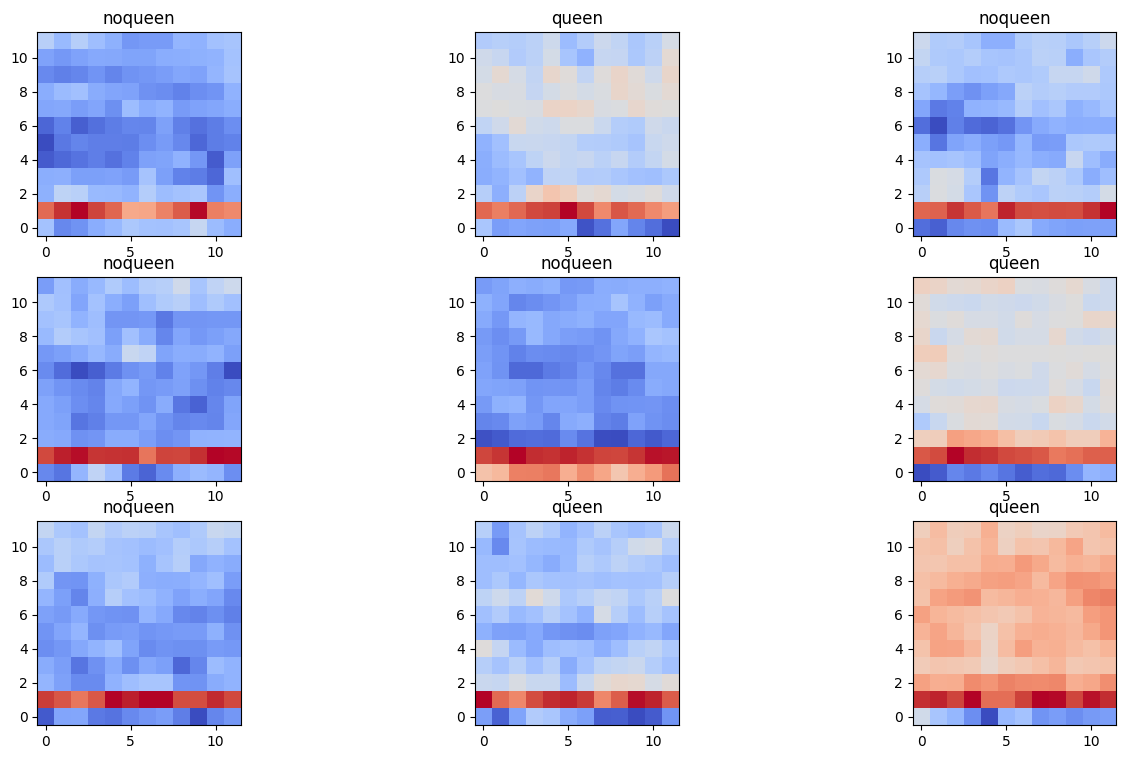

In [4]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [5]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
print(input_shape)
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

(12, 12, 1)


## Sequential

Epoch 1/10


2024-03-24 22:38:30.399491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-03-24 22:38:30.431570: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


31/31 [==============================] - 1s 22ms/step - loss: 0.8196 - accuracy: 0.5871 - val_loss: 0.6722 - val_accuracy: 0.5922
Epoch 2/10
31/31 [==============================] - 0s 11ms/step - loss: 0.5999 - accuracy: 0.6660 - val_loss: 0.6085 - val_accuracy: 0.6699
Epoch 3/10
31/31 [==============================] - 0s 11ms/step - loss: 0.5226 - accuracy: 0.7220 - val_loss: 0.5672 - val_accuracy: 0.7427
Epoch 4/10
31/31 [==============================] - 0s 11ms/step - loss: 0.4941 - accuracy: 0.7552 - val_loss: 0.5477 - val_accuracy: 0.7670
Epoch 5/10
31/31 [==============================] - 0s 11ms/step - loss: 0.4694 - accuracy: 0.7822 - val_loss: 0.5575 - val_accuracy: 0.7621
Epoch 6/10
31/31 [==============================] - 0s 11ms/step - loss: 0.4521 - accuracy: 0.7988 - val_loss: 0.5274 - val_accuracy: 0.7767
Epoch 7/10
31/31 [==============================] - 0s 11ms/step - loss: 0.4334 - accuracy: 0.8133 - val_loss: 0.5180 - val_accuracy: 0.8010
Epoch 8/10
31/31 [======

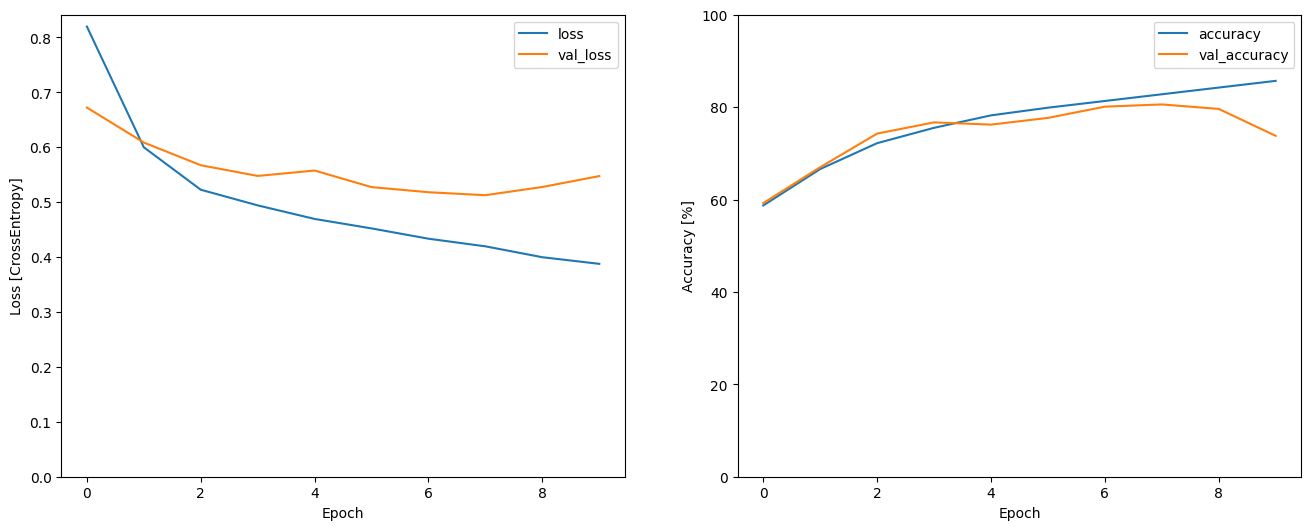

In [6]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

## Convolutional

Epoch 1/10
31/31 [==============================] - 1s 12ms/step - loss: 0.7556 - accuracy: 0.5270 - val_loss: 0.7238 - val_accuracy: 0.5194
Epoch 2/10
31/31 [==============================] - 0s 6ms/step - loss: 0.6464 - accuracy: 0.6037 - val_loss: 0.6350 - val_accuracy: 0.6650
Epoch 3/10
31/31 [==============================] - 0s 6ms/step - loss: 0.6140 - accuracy: 0.6701 - val_loss: 0.6120 - val_accuracy: 0.7087
Epoch 4/10
31/31 [==============================] - 0s 6ms/step - loss: 0.5959 - accuracy: 0.6888 - val_loss: 0.6161 - val_accuracy: 0.6893
Epoch 5/10
31/31 [==============================] - 0s 6ms/step - loss: 0.5816 - accuracy: 0.6743 - val_loss: 0.5877 - val_accuracy: 0.7184
Epoch 6/10
31/31 [==============================] - 0s 6ms/step - loss: 0.5693 - accuracy: 0.6826 - val_loss: 0.5706 - val_accuracy: 0.7524
Epoch 7/10
31/31 [==============================] - 0s 6ms/step - loss: 0.5612 - accuracy: 0.7075 - val_loss: 0.5902 - val_accuracy: 0.7039
Epoch 8/10
31/31 [=

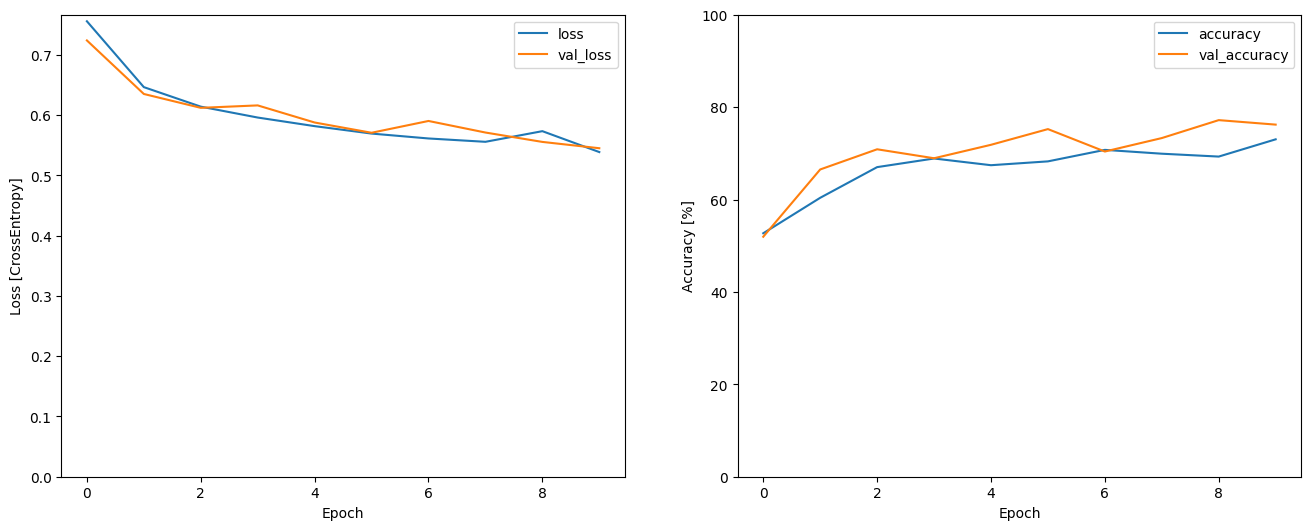

In [7]:
trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

# Summary

In [10]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f},   VL: {history.history['val_loss'][-1]:.2f}, VA: {history.history['val_accuracy'][-1]:.2f}" )

history_to_summary("Trained MFCCs + Seq ", trained_history_mfcc_seq)
history_to_summary("Trained MFCCs + Conv", trained_history_mfcc_conv)

Trained MFCCs + Seq :    Loss: 0.39, Acc: 0.86,   VL: 0.55, VA: 0.74
Trained MFCCs + Conv:    Loss: 0.54, Acc: 0.73,   VL: 0.54, VA: 0.76
